# Engine A: Behavioral DNA (Sequential Anomaly Detection)

This notebook builds the first and most critical engine of the Cognitive Shield framework. We will use a Transformer-based model to learn the deep sequential patterns in user behavior.

**Objective:** Train a model on sequences of *normal* user actions to create a "behavioral fingerprint." This model will then be able to identify fraudulent sessions because they will deviate from the learned normal patterns, resulting in a high anomaly score.

**Process:**
1.  **Load and Preprocess Data:** Load the generated `events.csv`.
2.  **Feature Engineering:**
    - Create a unified `event_token` from event type, channel, and amount.
    - Calculate `time_delta` between consecutive events.
    - Group events into sessions (our "sentences").
3.  **Build a PyTorch Dataset:** Prepare the data for the model, including tokenization, padding, and masking for the MLM task.
4.  **Define the Transformer Model:** Create the neural network architecture.
5.  **Train the Model:** Train the Transformer on legitimate sessions only.
6.  **Develop Anomaly Scoring:** Create a function to score new sessions based on how "surprising" they are to the model.
7.  **Evaluate:** Test the engine's ability to distinguish between normal and fraudulent sessions.

In [9]:
pip install torch

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import os

# --- Configuration ---
DATA_FILE = '../data/events.csv'
MODEL_SAVE_PATH = '../src/models/engine_a_transformer.pth'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model Hyperparameters
MAX_SEQ_LENGTH = 50  # Max events in a session
BATCH_SIZE = 32
EMBEDDING_DIM = 64
NUM_HEADS = 4
NUM_LAYERS = 2
LEARNING_RATE = 1e-4
EPOCHS = 5 # In a real scenario, this would be much higher

# Ensure model directory exists
os.makedirs('../src/models', exist_ok=True)

print(f"Using device: {DEVICE}")
print(f"Loading data from: {DATA_FILE}")

# Load the data
df = pd.read_csv(DATA_FILE, parse_dates=['timestamp'])
df = df.sort_values(by='timestamp').reset_index(drop=True)

print("Data loaded successfully.")
display(df.head())

Using device: cpu
Loading data from: ../data/events.csv
Data loaded successfully.


,event_id,user_id,timestamp,event_type,channel,amount,source_account,destination_account,device_id,ip_address,session_id,is_fraud
0,evt_cb95b14fdf9b,usr_9c73435ecbaa,2025-06-30 23:37:00+05:30,login_success,web_browser,0.00,acc_9c73435ecbaa,NaN,dev_6c4187fad28a,126.58.205.46,sess_78c0846b5447,False
1,evt_b70b72d6ffd9,usr_43ca4ced01d5,2025-06-30 23:37:00+05:30,login_success,web_browser,0.00,acc_43ca4ced01d5,NaN,dev_3ca1b360a357,164.109.173.147,sess_f76c862eaf29,False
2,evt_b85458c561d1,usr_9c73435ecbaa,2025-06-30 23:38:20+05:30,merchant_payment,web_browser,185.52,acc_9c73435ecbaa,mer_0b3027feabe1,dev_6c4187fad28a,126.58.205.46,sess_78c0846b5447,False
3,evt_258143911fb7,usr_9c73435ecbaa,2025-06-30 23:39:24+05:30,bill_pay,web_browser,2092.25,acc_9c73435ecbaa,util_company_2,dev_6c4187fad28a,126.58.205.46,sess_78c0846b5447,False
4,evt_6fe1088f6c95,usr_9f216b9a3801,2025-06-30 23:41:00+05:30,login_success,mobile_app,0.00,acc_9f216b9a3801,NaN,dev_eae0754b288c,206.187.228.206,sess_fb0bc76192d2,False


## 2. Feature Engineering & Sessionization

Here, we transform the raw event log into structured sequences that our model can understand.

- **Amount Bucketing:** We can't feed raw amounts to an embedding layer. We categorize them into buckets (`micro`, `small`, `medium`, `large`, `very_large`) based on quantiles. This makes the amount meaningful in a categorical sense.
- **Event Token Creation:** We combine `event_type`, `channel`, and the new `amount_bucket` into a single, rich categorical feature, our `event_token`.
- **Time Delta:** We calculate the time in seconds between an event and the previous one within the same session. This captures the user's *pace*.
- **Session Grouping:** We group the events by `session_id` to form our sequences.

In [11]:
# 1. Amount Bucketing
# For simplicity in this notebook, we'll use global quantiles.
# A more advanced approach would be per-user quantiles.
non_zero_amounts = df[df['amount'] > 0]['amount']
quantiles = non_zero_amounts.quantile([0.25, 0.5, 0.75, 0.95]).to_dict()

def amount_to_bucket(amount):
    if amount == 0:
        return 'no_amount'
    if amount <= quantiles[0.25]:
        return 'micro'
    elif amount <= quantiles[0.5]:
        return 'small'
    elif amount <= quantiles[0.75]:
        return 'medium'
    elif amount <= quantiles[0.95]:
        return 'large'
    else:
        return 'very_large'

df['amount_bucket'] = df['amount'].apply(amount_to_bucket)

# 2. Event Token Creation
df['event_token'] = df['event_type'] + '|' + df['channel'] + '|' + df['amount_bucket']

# 3. Time Delta Calculation
df['time_delta'] = df.groupby('session_id')['timestamp'].diff().dt.total_seconds().fillna(0)

# 4. Session Grouping
sessions = df.groupby('session_id').apply(lambda s: s[['event_token', 'time_delta', 'is_fraud']].to_dict(orient='records'))
sessions_df = pd.DataFrame(sessions, columns=['events']).reset_index()

# Separate normal and fraudulent sessions
sessions_df['is_fraud'] = sessions_df['events'].apply(lambda x: any(e['is_fraud'] for e in x))
normal_sessions = sessions_df[~sessions_df['is_fraud']]
fraud_sessions = sessions_df[sessions_df['is_fraud']]

print(f"Total sessions: {len(sessions_df)}")
print(f"Normal sessions: {len(normal_sessions)}")
print(f"Fraudulent sessions: {len(fraud_sessions)}")

print("\nSample processed session:")
display(sessions.iloc[0])

Total sessions: 88603
Normal sessions: 88453
Fraudulent sessions: 150

Sample processed session:


C:\Users\Sidhant\AppData\Local\Temp\ipykernel_20236\668661543.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sessions = df.groupby('session_id').apply(lambda s: s[['event_token', 'time_delta', 'is_fraud']].to_dict(orient='records'))


[{'event_token': 'login_success|mobile_app|no_amount',
  'time_delta': 0.0,
  'is_fraud': False},
 {'event_token': 'merchant_payment|mobile_app|medium',
  'time_delta': 148.0,
  'is_fraud': False},
 {'event_token': 'bulk_transfer|mobile_app|large',
  'time_delta': 75.0,
  'is_fraud': False},
 {'event_token': 'bulk_transfer|mobile_app|large',
  'time_delta': 19.0,
  'is_fraud': False},
 {'event_token': 'beneficiary_add|mobile_app|no_amount',
  'time_delta': 52.0,
  'is_fraud': False}]

## 3. Vocabulary and PyTorch Dataset

We create a vocabulary to map our categorical `event_token` and `time_delta` features to integer indices. Then, we build a custom PyTorch `Dataset` class that will handle tokenization, padding to a fixed length, and the crucial step of **Masked Language Modeling (MLM)**, where we randomly hide tokens for the model to predict.

In [12]:
# --- Vocabulary Creation ---
# Event Tokens
unique_tokens = df['event_token'].unique().tolist()
# Add special tokens
special_tokens = ['[PAD]', '[MASK]', '[CLS]', '[UNK]'] # CLS for start, UNK for unknown
event_vocab = {token: i for i, token in enumerate(special_tokens + unique_tokens)}
event_vocab_inv = {i: token for token, i in event_vocab.items()}

# Time Deltas (we bucketize them to create a small vocabulary)
def time_delta_to_bucket(delta):
    if delta < 1: return 'immediate'
    if delta < 60: return 'seconds'
    if delta < 3600: return 'minutes'
    if delta < 86400: return 'hours'
    return 'days'

df['time_bucket'] = df['time_delta'].apply(time_delta_to_bucket)
unique_time_buckets = df['time_bucket'].unique().tolist()
time_vocab = {bucket: i for i, bucket in enumerate(unique_time_buckets)}


# --- PyTorch Dataset Class ---
class SessionDataset(Dataset):
    def __init__(self, sessions, event_vocab, time_vocab, max_len):
        self.sessions = sessions
        self.event_vocab = event_vocab
        self.time_vocab = time_vocab
        self.max_len = max_len
        self.unk_token_id = event_vocab['[UNK]']

    def __len__(self):
        return len(self.sessions)

    def __getitem__(self, idx):
        session = self.sessions.iloc[idx]['events']
        
        # 1. Tokenize events and time deltas
        event_ids = [self.event_vocab.get(e['event_token'], self.unk_token_id) for e in session]
        time_deltas = [e['time_delta'] for e in session]
        time_ids = [self.time_vocab[time_delta_to_bucket(td)] for td in time_deltas]

        # 2. Truncate to max_len
        event_ids = event_ids[:self.max_len]
        time_ids = time_ids[:self.max_len]
        
        # 3. Create labels for MLM and mask input
        labels = torch.tensor(event_ids, dtype=torch.long)
        input_event_ids = labels.clone()
        
        # Masking logic (15% of tokens)
        rand = torch.rand(len(input_event_ids))
        mask_arr = (rand < 0.15)
        # Ensure we don't mask padding
        mask_arr[:1] = False # Don't mask start token
        
        for i in range(len(input_event_ids)):
            if mask_arr[i]:
                input_event_ids[i] = self.event_vocab['[MASK]']

        # 4. Padding
        pad_len = self.max_len - len(input_event_ids)
        
        padding = torch.full((pad_len,), self.event_vocab['[PAD]'], dtype=torch.long)
        input_event_ids = torch.cat([input_event_ids, padding])
        
        padding = torch.full((pad_len,), 0, dtype=torch.long) # Pad time with 0
        time_ids = torch.cat([torch.tensor(time_ids), padding])
        
        # We use -100 in labels for positions we don't want to calculate loss for (unmasked and padded)
        labels[~mask_arr] = -100 
        padding = torch.full((pad_len,), -100, dtype=torch.long)
        labels = torch.cat([labels, padding])
        
        # Attention mask to ignore padding
        attention_mask = (input_event_ids != self.event_vocab['[PAD]']).float()

        return {
            'event_ids': input_event_ids,
            'time_ids': time_ids,
            'attention_mask': attention_mask,
            'labels': labels
        }

# Create dataset and dataloader
train_sessions, val_sessions = train_test_split(normal_sessions, test_size=0.15, random_state=42)
train_dataset = SessionDataset(train_sessions, event_vocab, time_vocab, MAX_SEQ_LENGTH)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

print("Dataset and DataLoader created.")
# Let's check one sample
sample = train_dataset[0]
for key, val in sample.items():
    print(f"{key}: {val.shape}")

Dataset and DataLoader created.
event_ids: torch.Size([50])
time_ids: torch.Size([50])
attention_mask: torch.Size([50])
labels: torch.Size([50])


## 4. Define the Transformer Model

Now we build the brain of Engine A. Our model consists of three main parts:
1.  **Embedding Layer:** This layer converts our integer-indexed tokens (for both events and time buckets) into dense vector representations (embeddings). We add these two embeddings together to get a single, rich representation for each event in the sequence.
2.  **Positional Encoding:** Transformers don't inherently understand the order of a sequence. We add a positional encoding to the embeddings to give the model information about the position of each event in the session.
3.  **Transformer Encoder:** This is the core of the model. It uses multiple layers of self-attention to learn the complex relationships and "grammar" between events in a sequence.
4.  **MLM Head:** A final linear layer that takes the output from the Transformer and predicts the original token for the masked positions in the input.

In [13]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class BehavioralTransformer(nn.Module):
    def __init__(self, n_event_tokens, n_time_tokens, embed_dim, n_heads, n_layers, max_seq_len):
        super().__init__()
        self.event_embedding = nn.Embedding(n_event_tokens, embed_dim)
        self.time_embedding = nn.Embedding(n_time_tokens, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim, max_seq_len)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, 
            nhead=n_heads, 
            batch_first=True, # This is important!
            dim_feedforward=embed_dim * 4
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        
        # MLM Head: A linear layer to map transformer output back to vocabulary size
        self.mlm_head = nn.Linear(embed_dim, n_event_tokens)

    def forward(self, event_ids, time_ids, attention_mask):
        # The attention mask needs to be boolean for the TransformerEncoder
        # PyTorch expects True for positions to be attended to, False for masked positions
        src_key_padding_mask = (attention_mask == 0)

        event_embed = self.event_embedding(event_ids)
        time_embed = self.time_embedding(time_ids)
        
        # Combine embeddings
        x = event_embed + time_embed
        x = self.pos_encoder(x)
        
        # Pass through transformer
        output = self.transformer_encoder(x, src_key_padding_mask=src_key_padding_mask)
        
        # Get predictions for the MLM task
        mlm_predictions = self.mlm_head(output)
        
        return mlm_predictions

# Instantiate the model
model = BehavioralTransformer(
    n_event_tokens=len(event_vocab),
    n_time_tokens=len(time_vocab),
    embed_dim=EMBEDDING_DIM,
    n_heads=NUM_HEADS,
    n_layers=NUM_LAYERS,
    max_seq_len=MAX_SEQ_LENGTH
).to(DEVICE)

print("Model Architecture:")
print(model)

Model Architecture:
BehavioralTransformer(
  (event_embedding): Embedding(47, 64)
  (time_embedding): Embedding(3, 64)
  (pos_encoder): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (mlm_head): Linear(in_features=64, out_features=47, bias=True)
)


## 5. Train the Model

This is where the learning happens. We loop through our training data for a set number of epochs. In each step:
1.  We pass a batch of masked sequences to the model.
2.  The model predicts the identity of the masked tokens.
3.  We use a `CrossEntropyLoss` function to compare the model's predictions to the true, unmasked tokens. The loss is only calculated for the tokens that were actually masked (where the label is not -100).
4.  We use this loss to update the model's weights through backpropagation.

**Note:** For a hackathon, we'll run for only a few epochs. A production model would train for much longer on a much larger dataset.

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# The loss function ignores the label -100, which is exactly what we need
criterion = nn.CrossEntropyLoss(ignore_index=-100) 

model.train() # Set the model to training mode

for epoch in range(EPOCHS):
    loop = tqdm(train_loader, leave=True)
    total_loss = 0
    
    for batch in loop:
        # Move batch to device
        event_ids = batch['event_ids'].to(DEVICE)
        time_ids = batch['time_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        # Forward pass
        optimizer.zero_grad()
        predictions = model(event_ids, time_ids, attention_mask)

        # Calculate loss
        # Reshape for CrossEntropyLoss: (Batch_size * Seq_len, Vocab_size) and (Batch_size * Seq_len)
        loss = criterion(predictions.view(-1, len(event_vocab)), labels.view(-1))
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        loop.set_description(f"Epoch [{epoch+1}/{EPOCHS}]")
        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{EPOCHS}, Average Training Loss: {avg_loss:.4f}")

# Save the trained model
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")

  0%|          | 0/2350 [00:00<?, ?it/s]

Epoch 1/5, Average Training Loss: 2.3183


  0%|          | 0/2350 [00:00<?, ?it/s]

Epoch 2/5, Average Training Loss: 1.8976


  0%|          | 0/2350 [00:00<?, ?it/s]

Epoch 3/5, Average Training Loss: 1.8280


  0%|          | 0/2350 [00:00<?, ?it/s]

Epoch 4/5, Average Training Loss: 1.8129


  0%|          | 0/2350 [00:00<?, ?it/s]

Epoch 5/5, Average Training Loss: 1.8101
Model saved to ../src/models/engine_a_transformer.pth


## 6. Anomaly Scoring & Evaluation

Now for the payoff. How do we use our trained model to detect fraud?

The core idea is that the model, having been trained only on *normal* data, will be very good at predicting masked tokens in a normal session, resulting in a **low loss**. Conversely, when faced with a fraudulent session that has an unnatural sequence or timing, its predictions will be poor, resulting in a **high loss**. This loss value becomes our **Behavioral Anomaly Score**.

We will:
1.  Create a function `get_anomaly_score` that computes this loss for any given session.
2.  Calculate scores for all our normal validation sessions and all fraudulent sessions.
3.  Visualize the distribution of these scores to see if our engine can effectively separate the two populations.

Calculating Anomaly Scores:   0%|          | 0/32 [00:00<?, ?it/s]

Calculating Anomaly Scores:   0%|          | 0/5 [00:00<?, ?it/s]

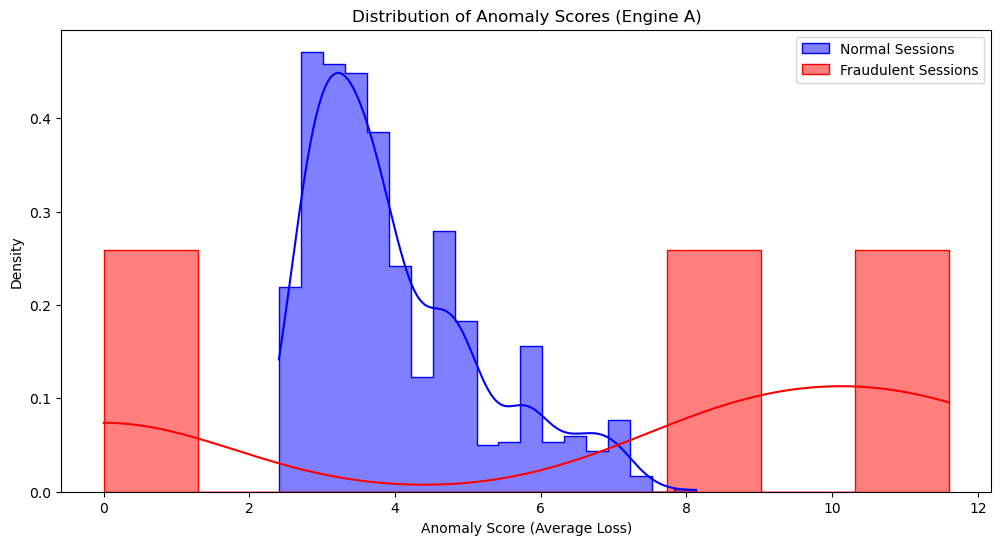

In [15]:
# Create a new dataset class for inference that doesn't do masking
class InferenceDataset(Dataset):
    def __init__(self, sessions, event_vocab, time_vocab, max_len):
        self.sessions = sessions
        self.event_vocab = event_vocab
        self.time_vocab = time_vocab
        self.max_len = max_len
        self.unk_token_id = event_vocab['[UNK]']

    def __len__(self):
        return len(self.sessions)

    def __getitem__(self, idx):
        session = self.sessions.iloc[idx]['events']
        
        event_ids = [self.event_vocab.get(e['event_token'], self.unk_token_id) for e in session]
        time_deltas = [e['time_delta'] for e in session]
        time_ids = [self.time_vocab[time_delta_to_bucket(td)] for td in time_deltas]

        event_ids = event_ids[:self.max_len]
        time_ids = time_ids[:self.max_len]
        
        labels = torch.tensor(event_ids, dtype=torch.long)
        
        # Padding
        pad_len = self.max_len - len(event_ids)
        padding = torch.full((pad_len,), self.event_vocab['[PAD]'], dtype=torch.long)
        event_ids_padded = torch.cat([torch.tensor(event_ids), padding])
        time_ids_padded = torch.cat([torch.tensor(time_ids), torch.full((pad_len,), 0)])
        
        # Set all labels to -100 so we can selectively unmask them for scoring
        labels_padded = torch.cat([labels, torch.full((pad_len,), -100, dtype=torch.long)])

        return {
            'event_ids': event_ids_padded,
            'time_ids': time_ids_padded,
            'labels': labels_padded
        }


def get_anomaly_scores(sessions_df, model, batch_size=32):
    model.eval() # Set model to evaluation mode
    scores = []
    
    dataset = InferenceDataset(sessions_df, event_vocab, time_vocab, MAX_SEQ_LENGTH)
    loader = DataLoader(dataset, batch_size=batch_size)
    
    with torch.no_grad():
        for batch in tqdm(loader, desc="Calculating Anomaly Scores"):
            event_ids = batch['event_ids'].to(DEVICE)
            time_ids = batch['time_ids'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)
            
            # For each sequence, mask one token at a time and get loss
            batch_scores = []
            for i in range(event_ids.size(0)): # Iterate through each item in the batch
                seq_len = (labels[i] != -100).sum().item()
                if seq_len < 2: 
                    batch_scores.append(0) # Not enough context to score
                    continue

                total_seq_loss = 0
                # Mask and predict each token in the sequence one by one
                for j in range(1, seq_len): # Don't mask the first token
                    masked_event_ids = event_ids[i].clone().unsqueeze(0)
                    masked_event_ids[0, j] = event_vocab['[MASK]']
                    
                    # Attention mask should be all 1s as no padding is real
                    attn_mask = (masked_event_ids != event_vocab['[PAD]']).float()

                    predictions = model(masked_event_ids, time_ids[i].unsqueeze(0), attn_mask)
                    
                    # Calculate loss for just the masked token
                    loss = criterion(predictions.view(-1, len(event_vocab)), labels[i].unsqueeze(0).view(-1))
                    total_seq_loss += loss.item()

                avg_loss = total_seq_loss / (seq_len - 1) if seq_len > 1 else 0
                batch_scores.append(avg_loss)
            scores.extend(batch_scores)
            
    return np.array(scores)

# --- Evaluation ---
# Calculate scores for a sample of normal and fraud sessions
normal_eval_sessions = val_sessions.sample(n=min(len(val_sessions), 1000), random_state=42)
fraud_eval_sessions = fraud_sessions.sample(n=min(len(fraud_sessions), 1000), random_state=42)

normal_scores = get_anomaly_scores(normal_eval_sessions, model)
fraud_scores = get_anomaly_scores(fraud_eval_sessions, model)

# Visualize the distributions
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(normal_scores, color="blue", label='Normal Sessions', kde=True, stat="density", element="step")
sns.histplot(fraud_scores, color="red", label='Fraudulent Sessions', kde=True, stat="density", element="step")
plt.title('Distribution of Anomaly Scores (Engine A)')
plt.xlabel('Anomaly Score (Average Loss)')
plt.legend()
plt.show()